# 1.2 Visualize the Optimization Process

## Import libraries

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

/Users/andrewwright/opt/anaconda3/envs/py311env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andrewwright/opt/anaconda3/envs/py311env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/andrewwright/opt/anaconda3/envs/py311env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/andrewwright/opt/anaconda3/envs/py311env/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


## Define and Plot Function

In [3]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

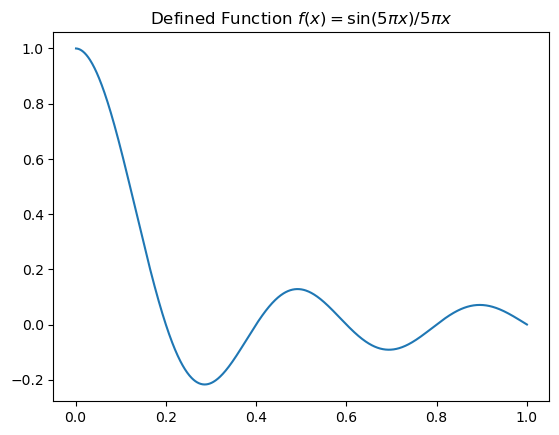

In [4]:
### Plot fn
xvec = torch.linspace(0,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.show()

## Load Data

In [5]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


## View Image

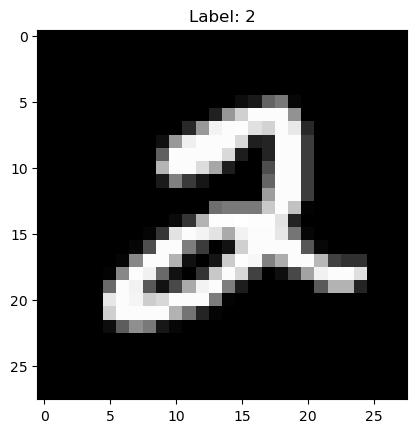

In [6]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Define Model Class

In [80]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

## Train & Eval Function
### With collecting model params

In [84]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    model_weights = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        print(f"train loss: {train_loss}")

        # Collect parameters
        weights = [p.data.clone() for p in model.parameters()]
        model_weights.append(weights)
        
        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, model_weights

## Specify Model

In [85]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

## Train Model

In [86]:
m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)

train loss: 0.6659037470817566
Accuracy of the network on the 10000 test images: 90.07 %
train loss: 0.3051297962665558
Accuracy of the network on the 10000 test images: 92.88 %


In [92]:
print(type(m1_weights))

<class 'list'>


In [116]:
print(m1_weights[1][8].shape)

torch.Size([12, 23])


In [125]:
epoch_ct = 0
for epoch in m1_weights:
    event_ct = 0
    for event in epoch:
        print(f"epoch {epoch_ct}, event {event_ct}; is size {event.shape}")
        event_ct += 1
    epoch_ct += 1

epoch 0, event 0; is size torch.Size([17, 784])
epoch 0, event 1; is size torch.Size([17])
epoch 0, event 2; is size torch.Size([26, 17])
epoch 0, event 3; is size torch.Size([26])
epoch 0, event 4; is size torch.Size([25, 26])
epoch 0, event 5; is size torch.Size([25])
epoch 0, event 6; is size torch.Size([23, 25])
epoch 0, event 7; is size torch.Size([23])
epoch 0, event 8; is size torch.Size([12, 23])
epoch 0, event 9; is size torch.Size([12])
epoch 0, event 10; is size torch.Size([10, 12])
epoch 0, event 11; is size torch.Size([10])
epoch 1, event 0; is size torch.Size([17, 784])
epoch 1, event 1; is size torch.Size([17])
epoch 1, event 2; is size torch.Size([26, 17])
epoch 1, event 3; is size torch.Size([26])
epoch 1, event 4; is size torch.Size([25, 26])
epoch 1, event 5; is size torch.Size([25])
epoch 1, event 6; is size torch.Size([23, 25])
epoch 1, event 7; is size torch.Size([23])
epoch 1, event 8; is size torch.Size([12, 23])
epoch 1, event 9; is size torch.Size([12])
epoch 

## Gradient Norm

In [126]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

## Train & Eval Function
### With gradient norm function

In [ ]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    gradient = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        gradient.append(gradient_norm(model))
        print(f"train loss: {train_loss}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, gradient

In [ ]:
### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):
  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
  return loss_vec, gradient

In [ ]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

In [ ]:
### Train on MNIST
m1_loss, m1_acc, m1_grad = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)

In [ ]:
### Train on fn(x)
x_train = torch.linspace(0,1,1000)
y_train = fn(x_train)
# Train the model
model1_loss, model1_grad = train_model(model1, x_train, y_train, batch = 50, epochs = 10, learning_rate = 0.001)